# Fir filter design with Python and Scipy

In [1]:
from scipy import signal
from pylab import *
from scipy.signal import freqz
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, lfilter, firwin, freqz

## 16-taps FIR filter 
First of all, let's generate the coefficient of the 16-tap Fir Filter, this is done by implementing the module `scipy.signal`.

In [2]:
#Frequency
fs = 400.0 # Hz 

#n_taps 
n_taps = 16

# Cutoff frequency of the filter.
cutoff_hz = 0.1

coefficients = signal.firwin(n_taps, cutoff_hz, pass_zero= 'lowpass', fs = fs)
coefficients

array([0.00977976, 0.0146415 , 0.02838606, 0.04863697, 0.07189272,
       0.09413216, 0.11150985, 0.12102099, 0.12102099, 0.11150985,
       0.09413216, 0.07189272, 0.04863697, 0.02838606, 0.0146415 ,
       0.00977976])

In [3]:
#Compute the frequency response of the filter. w is the array of frequencies, and h is the corresponding complex array of frequency responses.
w, h = signal.freqz(coefficients)
h_dB = 20 * np.log10(abs(h))

Text(0.5, 1.0, 'Phase response')

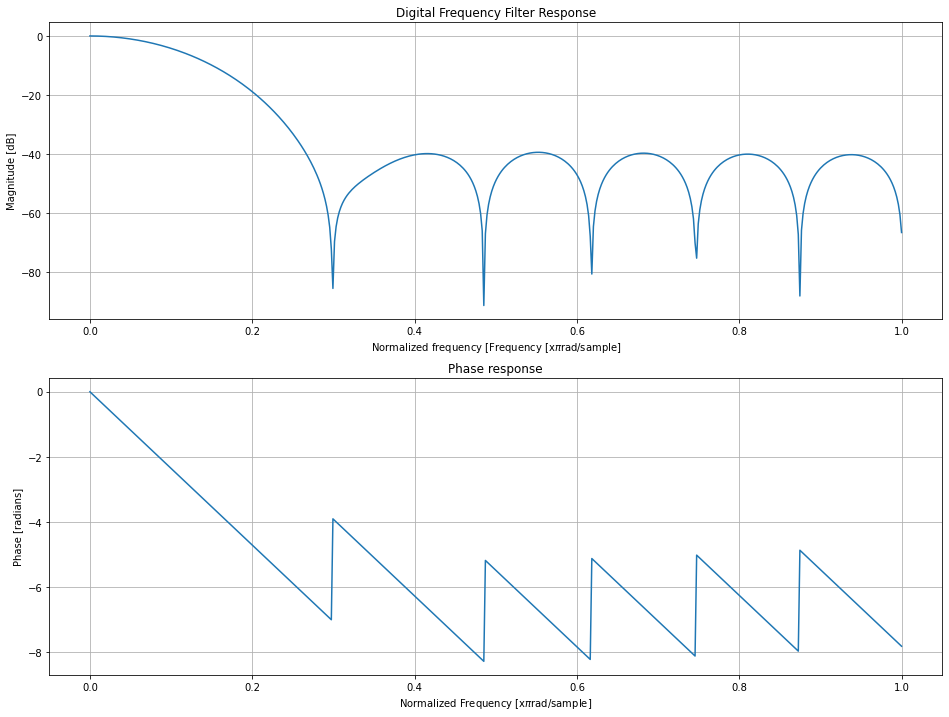

In [4]:
#Plots o the response of the digital filter
fig = plt.figure()
fig.set_size_inches(16, 12, forward=True)
ax1 = fig.add_subplot(211)   
ax1.plot(w/max(w), h_dB) 
ax1.set_xlabel('Normalized frequency [Frequency [x$\pi$rad/sample]')
ax1.set_ylabel('Magnitude [dB]')
ax1.set_title('Digital Frequency Filter Response')
ax1.grid()

h_Phase = unwrap(arctan2(imag(h),real(h)))
ax2 = fig.add_subplot(212)
ax2.plot(w/max(w),h_Phase) 
ax2.set_xlabel(r'Normalized Frequency [x$\pi$rad/sample]')
ax2.set_ylabel('Phase [radians]')
ax2.grid()
ax2.set_title(r'Phase response')

## Input signal:  Sine Wave
We generate a combination of 3 sinusoidal function with different frequencies and amplitudes.

In [5]:
#first let's create a sine wave
def sine_wave(A, xs, f):
    return A * np.sin(2 * np.pi * f * xs)

F_1 = 1
A_1 = 10
 
F_2 = 500
A_2 = 3

F_3 = 180
A_3 = 3
 
t = np.linspace(0, 2, 400)
input_signal_sine = sine_wave(A_1, t, F_1) + sine_wave(A_2, t, F_2) + sine_wave(A_3, t, F_3)

The implementation of the FIR filter by Python it is done by using `lfilter`

In [6]:
filtered_x = lfilter(coefficients, 1.0, input_signal_sine)

#### Scale of the coefficients in order to implement it into VHDL - 16-taps

All is left is to compute the FIR filter in VHDL and compare. 
Since VHDL soes not support float operations, we have to do a scaling of the coefficient and the inpt data this is done by just applyign a scaling of 1000.

In [7]:
scaling = 10000
coefficients_scaled = np.round(coefficients*scaling).astype(integer) 
input_signal_scaled_sine = np.round(input_signal_sine*scaling)
#save to load in VHDL then
np.savetxt("input_vectors.txt", input_signal_scaled_sine, fmt='%d')
np.savetxt("coefficients.txt", coefficients_scaled, fmt='%d')

#### Comparison of the FIR filter with Python and VHDL

In [8]:
# we load the FIR filter implemented using VHDL
output_vhdl = np.loadtxt("output_results.txt")

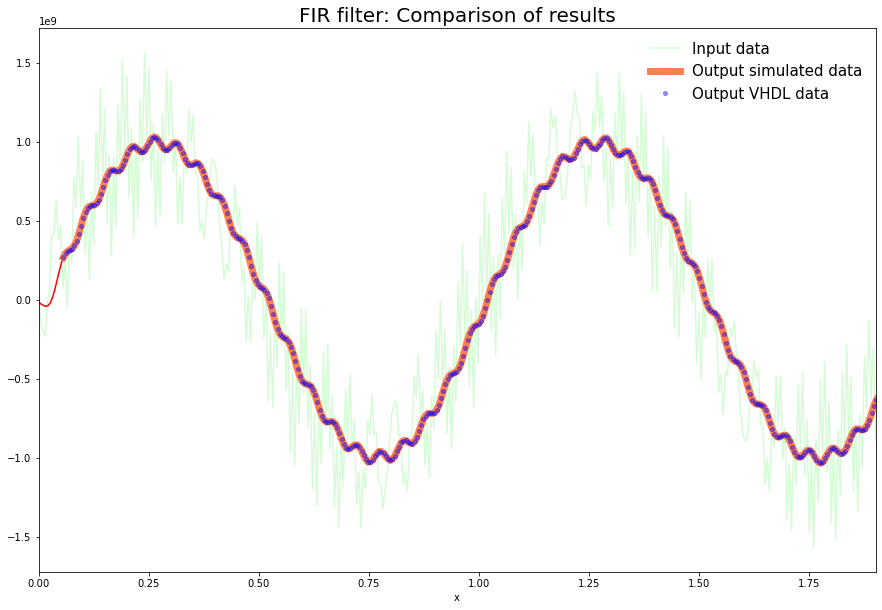

In [9]:
plt.figure(figsize=(15,10))
# The phase delay of the filtered signal.
delay = 0.5 * (n_taps-1) / 400


# Plot the original signal.
plot(t, input_signal_scaled_sine*scaling,  label='Input data', color = 'palegreen', alpha = 0.4)
plt.title("FIR filter: Comparison of results", fontsize=20, family="sans-serif")
# Plot the filtered signal, shifted to compensate for the phase delay.

plot(t-delay, filtered_x*1e8, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.

plot(t[n_taps-1:]-delay, filtered_x[n_taps-1:]*1e8, 'coral', label = 'Output simulated data', linewidth = 7)
plot(t[n_taps-1:]-delay, output_vhdl[0:len(t[n_taps-1:])],  'o',color = 'blue', label = 'Output VHDL data', markersize = 4, alpha = 0.4)
xlabel('x')
xlim(0,1.9)

legend( frameon=False, fontsize=15)
show()

## Implemetantion of a 5-tap FIR filter with sine wave as input signal

We generate the coefficients the same way as before and scaled them 

In [10]:
#Frequency
fs = 400.0 # Hz 

#n_taps 
n_taps = 5

# Cutoff frequency of the filter.
cutoff_hz = 0.1

coefficients_5 = signal.firwin(n_taps, cutoff_hz, pass_zero= 'lowpass', fs = fs)
coefficients_5

coefficients_scaled_5 = np.round(coefficients_5*scaling).astype(integer) 
#saving data - we use the same input as before
np.savetxt("coefficients.txt", coefficients_scaled_5, fmt='%d')

We compare the output from the simulation Python and the VHDL

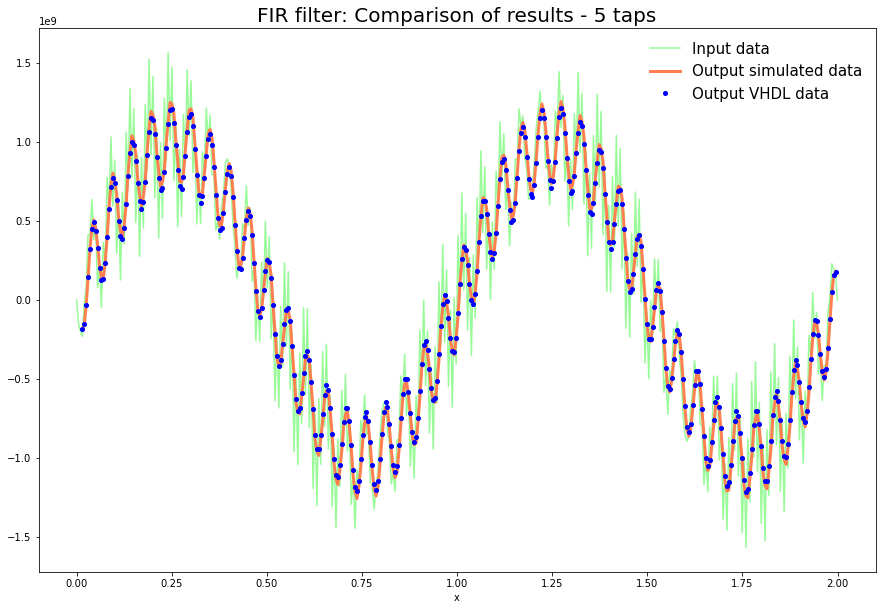

In [11]:
# FIR filter implemented using VHDL, vivado simulation
# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(coefficients_5, 1.0, input_signal_scaled_sine)
# load in VHDL then
output_vhdl = np.loadtxt("output_results_sine_five.txt")

plt.figure(figsize=(15,10))
delay = 0.5 * (n_taps-1) / 400
# Plot the original signal.
plot(t, input_signal_scaled_sine*scaling,  label='Input data', color = 'palegreen', alpha = 1)
plt.title("FIR filter: Comparison of results - 5 taps", fontsize=20, family="sans-serif")
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t[n_taps-1:]-delay, filtered_x[n_taps-1:]*scaling, 'coral', label = 'Output simulated data', linewidth = 3)
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[n_taps-1:]-delay, output_vhdl[0:len(t[n_taps-1:])],  'o',color = 'blue', label = 'Output VHDL data', markersize = 4, alpha = 1)
xlabel('x')
legend( frameon=False, fontsize=15)
show()

## Implemetantion of a 16-tap FIR filter with Square wave as input signal

We generate the coefficients the same way as before and scaled them 

Generation of the square wave

In [12]:
#A 5 Hz waveform sampled at 400 Hz for 1 second:
t = np.linspace(0, 1, 400)
input_signal_square = signal.square(2 * np.pi * 5 * t)
# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(coefficients, 1.0, input_signal_square)

In [13]:
#scaling data
input_signal_scaled_square = np.round(input_signal_square*scaling)

#save to load in VHDL then
np.savetxt("input_vectors_square.txt", input_signal_scaled_square, fmt='%d')

In [14]:
# FIR filter implemented using VHDL, vivado simulation
output_vhdl = np.loadtxt("output_results_square.txt")

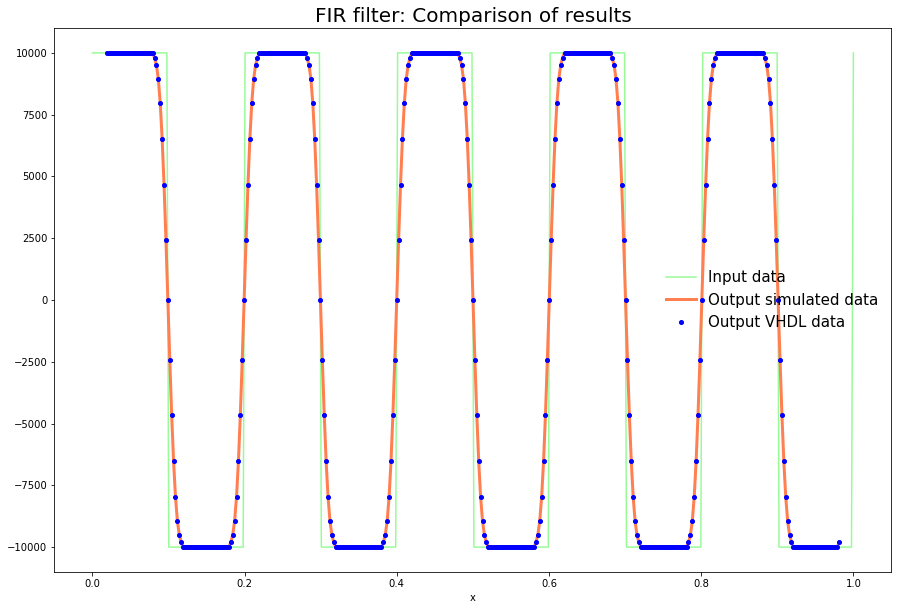

In [15]:
plt.figure(figsize=(15,10))
n_taps = 16
# The phase delay of the filtered signal.
delay = 0.5 * (n_taps-1) / 400
# Plot the original signal.
plot(t, input_signal_scaled_square,  label='Input data', color = 'palegreen', alpha = 1)
plt.title("FIR filter: Comparison of results", fontsize=20, family="sans-serif")
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t[n_taps-1:]-delay, filtered_x[n_taps-1:]*scaling, 'coral', label = 'Output simulated data', linewidth = 3)
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[n_taps-1:]-delay, output_vhdl[0:len(t[n_taps-1:])]/scaling,  'o',color = 'blue', label = 'Output VHDL data', markersize = 4, alpha = 1)
xlabel('x')
legend( frameon=False, fontsize=15)
show()